# Moosic Baseline Model :: Iteration v1


* combining datasets as done prior [data preprocessing][data management]
* train test split [modelling]
* baseline model [discussion needed]
* baseline model sketch and implementation


## Importing required libraries




In [1]:
# IMPORT LIBRARIES


try:

    import numpy as np
    import pandas as pd
    import random as rnd
    #from tqdm.notebook import tqdm as tqdm
    from tqdm import tqdm 
    #from .autonotebook import tqdm as notebook_tqdm

    # databases - sql
    #from dotenv import dotenv_values
    #import sqlalchemy

    # visualisation
    import seaborn as sns
    import matplotlib.pyplot as plt

    # split data - avoid data leakage
    from sklearn.model_selection import train_test_split

    # preprocessing, scaling
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler

    # modelling
    from sklearn.cluster import KMeans

    # cross validation, hyperparameter tuning
    #from surprise.model_selection import GridSearchCV
    from sklearn.model_selection import GridSearchCV

    # metrics
    from sklearn.metrics import euclidean_distances
    from sklearn.metrics.pairwise import sigmoid_kernel
    from sklearn.metrics.pairwise import cosine_similarity

    # high dimensional usage - dimensionality reduction
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA

    # text converter/vectorizer
    from sentence_transformers import SentenceTransformer
    from sklearn.feature_extraction.text import CountVectorizer

    # pipeline
    from sklearn.pipeline import Pipeline



except ImportError as error:
    print(f"Installation of the required dependencies necessary! {error}")

    %pip install numpy
    %pip install pandas
    #%pip install dotenv
    #%pip install sqlalchemy
    %pip install seaborn
    %pip install matplotlib
    %pip install scikit-learn
    %pip install tqdm
    %pip install ipywidgets
    %pip install scikit-surprise
    %pip install sentence-transformers

    print(f"Successful installation of the required dependencies necessary")


import warnings
warnings.filterwarnings('ignore')



## Loading the data

In [3]:
# load the data files for artists and tracks


df_artists = pd.read_csv('../data/moosic-raw/spotify_600k_artists.csv', low_memory=False)
df_tracks = pd.read_csv('../data/moosic-raw/spotify_600k_tracks.csv', low_memory=False)


# get shape of the artist and tracks dataframe

print(f"Artists data: There are {df_artists.shape[0]} observations and {df_artists.shape[1]} feature variables ")
print('----------'*10)
print(f"Music Track data: There are {df_tracks.shape[0]} observations and {df_tracks.shape[1]} feature variables ")
print('----------'*10)


Artists data: There are 1162095 observations and 5 feature variables 
----------------------------------------------------------------------------------------------------
Music Track data: There are 586672 observations and 20 feature variables 
----------------------------------------------------------------------------------------------------


## Data Overview Artists

| column | additional information |
|--------|------------------------|
| id | id of artist |
| followers | number of followers | 
| genres | genres associated with artist |
| name | name of artist |
| popularity | popularity of artist in range 0 to 100 |

## Data Overview Tracks

| column | additional information |
|--------|------------------------|
| id | id of track |
| name | name of track | 
| popularity | popularity of track in range 0 to 100 |
| duration_ms | duration of songs in ms |
| explicit | whether it contains explicit content or not |
| artists | artists who created the track | 
| id_artists | id of artists who created the track |
| release_date | date of release |
| danceability | how danceable a song is in range 0 to 1 |
| energy | how energized a song is in range 0 to 1 |
| key | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1 |
| loudness | The overall loudness of a track in decibels (dB) |
| mode |  Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0 |
| speechiness | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks |
| acousticness | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic |
| instrumentalness | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content |
| liveness | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live |
| valence | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry) |
| tempo | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration | 
| time_signature | An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4. | 

In [4]:
## display the info of the data files 

# spotify music tracks and audio features data
display(df_tracks.info())
print('------'*10)

# spotify artist  metadata
display(df_artists.info())
print('------'*10)

# display a transposed sample of the data file
display(df_tracks.head().T)
print('------'*10)
display(df_artists.head().T)
print('------'*10)

# display the number of unique values in the artists and music tracks data
display(df_artists.nunique())
print('------'*10)
display(df_tracks.nunique())
print('------'*10)







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

None

------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162095 entries, 0 to 1162094
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1162095 non-null  object 
 1   followers   1162084 non-null  float64
 2   genres      1162095 non-null  object 
 3   name        1162092 non-null  object 
 4   popularity  1162095 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 44.3+ MB


None

------------------------------------------------------------


,0,1,2,3,4
id,35iwgR4jXetI318WEWsa1Q,021ht4sdgPcrDgSk7JTbKY,07A5yehtSnoedViJAZkNnc,08FmqUhxtyLTn6pAh6bk45,08y9GfoqCWfOGsKdwojr5e
name,Carve,Capítulo 2.16 - Banquero Anarquista,Vivo para Quererte - Remasterizado,El Prisionero - Remasterizado,Lady of the Evening
popularity,6,0,0,0,0
duration_ms,126903,98200,181640,176907,163080
explicit,0,0,0,0,0
artists,['Uli'],['Fernando Pessoa'],['Ignacio Corsini'],['Ignacio Corsini'],['Dick Haymes']
id_artists,['45tIt06XoI0Iio4LBEVpls'],['14jtPCOoNZwquk5wd9DxrY'],['5LiOoJbxVSAMkBS2fUm3X2'],['5LiOoJbxVSAMkBS2fUm3X2'],['3BiJGZsyX9sJchTqcSA7Su']
release_date,1922-02-22,1922-06-01,1922-03-21,1922-03-21,1922
danceability,0.645,0.695,0.434,0.321,0.402
energy,0.445,0.263,0.177,0.0946,0.158


------------------------------------------------------------


,0,1,2,3,4
id,0DheY5irMjBUeLybbCUEZ2,0DlhY15l3wsrnlfGio2bjU,0DmRESX2JknGPQyO15yxg7,0DmhnbHjm1qw6NCYPeZNgJ,0Dn11fWM7vHQ3rinvWEl4E
followers,0.0,5.0,0.0,0.0,2.0
genres,[],[],[],[],[]
name,Armid & Amir Zare Pashai feat. Sara Rouzbehani,ปูนา ภาวิณี,Sadaa,Tra'gruda,Ioannis Panoutsopoulos
popularity,0,0,0,0,0


------------------------------------------------------------


id            1162095
followers       51998
genres          49155
name          1134429
popularity         99
dtype: int64

------------------------------------------------------------


id                  586672
name                446474
popularity             101
duration_ms         123122
explicit                 2
artists             114030
id_artists          115062
release_date         19700
danceability          1285
energy                2571
key                     12
loudness             29196
mode                     2
speechiness           1655
acousticness          5217
instrumentalness      5402
liveness              1782
valence               1805
tempo               122706
time_signature           5
dtype: int64

------------------------------------------------------------


In [5]:
# for the music tracks dataset: 
# -  check for number of null values in each columns

display(df_tracks.isnull().sum())
print('------'*10)

# - drop null / NaNs values in columns

df_tracks = df_tracks.dropna()
print('------'*10)

# - re-check for number of null values in each columns

display(df_tracks.isnull().sum())
print('------'*10)

# - check for duplicates

display(df_tracks.duplicated())
print('------'*10)

# get count of duplicated values in tracks dataframe

display(df_tracks.duplicated().value_counts())
print('------'*10)

# show top 5 rows of data (transposed)

display(df_tracks.head().T)
print('------'*10)



id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

------------------------------------------------------------
------------------------------------------------------------


id                  0
name                0
popularity          0
duration_ms         0
explicit            0
artists             0
id_artists          0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

------------------------------------------------------------


0         False
1         False
2         False
3         False
4         False
          ...  
586667    False
586668    False
586669    False
586670    False
586671    False
Length: 586601, dtype: bool

------------------------------------------------------------


False    586601
Name: count, dtype: int64

------------------------------------------------------------


,0,1,2,3,4
id,35iwgR4jXetI318WEWsa1Q,021ht4sdgPcrDgSk7JTbKY,07A5yehtSnoedViJAZkNnc,08FmqUhxtyLTn6pAh6bk45,08y9GfoqCWfOGsKdwojr5e
name,Carve,Capítulo 2.16 - Banquero Anarquista,Vivo para Quererte - Remasterizado,El Prisionero - Remasterizado,Lady of the Evening
popularity,6,0,0,0,0
duration_ms,126903,98200,181640,176907,163080
explicit,0,0,0,0,0
artists,['Uli'],['Fernando Pessoa'],['Ignacio Corsini'],['Ignacio Corsini'],['Dick Haymes']
id_artists,['45tIt06XoI0Iio4LBEVpls'],['14jtPCOoNZwquk5wd9DxrY'],['5LiOoJbxVSAMkBS2fUm3X2'],['5LiOoJbxVSAMkBS2fUm3X2'],['3BiJGZsyX9sJchTqcSA7Su']
release_date,1922-02-22,1922-06-01,1922-03-21,1922-03-21,1922
danceability,0.645,0.695,0.434,0.321,0.402
energy,0.445,0.263,0.177,0.0946,0.158


------------------------------------------------------------


The tracks-csv has all the data we need. From this time on we will only work with the tracks data.
We will split the data to avoid data leakage.

In [23]:
# train-test split the music track data with the target as the music name for the baseline model

# Defining X and y
features = df_tracks.columns.tolist()
features.remove('name')

X = df_tracks[features]
y = df_tracks['name']

# y = df_tracks['name'].values.reshape(-1,1)
# print(y)

print(X.shape)
print(y.shape)


# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True) #, stratify=y)

# Check the shape of the data sets
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)




(586601, 19)
(586601,)
X_train: (439950, 19)
y_train: (439950,)
X_test: (146651, 19)
y_test: (146651,)


When we use 

 ```
stratify=y 
```

we get a ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2. 

This because of the nature of stratification. The stratify parameter set it to split data in a way to allocate test_size amount of data to each class. In this case, you don't have sufficient class labels of one of your classes to keep the data splitting ratio equal to test_size.

I confirm the above explanation. I have encountered this situation when dealing with a class that has a very low count . You can either take a random sample (not stratified) or try different test_size values, to be able to have an adequate size that could hold all your various labels.


---

# BASELINE MODELS SKETCH AND IMPLEMENTATION

------------------------------------

> We have 586672 observations and 20 feature variables in our current (initial) dataset

```python

all_features =  ['id', 'name',
    'popularity', 'duration_ms', 'explicit',
    'artists', 'id_artists','release_date',
    'danceability','energy', 'key',
    'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness',
    'liveness','valence','tempo',
    'time_signature']
```

#### Baseline model sketch


> baseline recommender: 

* baseline focus : 
    - similarity :  measure similarity values based on the audio feature clusters of the music tracks, if popularity is greater than 0.7 then recommend top N song names and/or most similar content
    - get  N or top N number of tracks based on user choice in similar clusters of the audio features used 

* baseline features :
    - all features + genre? except id, id_artists

* baseline model algorithm
    - content based recommender for item-item based on audio features 




In [24]:
# all features

all_features =  ['id', 'name',
    'popularity', 'duration_ms', 'explicit',
    'artists', 'id_artists','release_date',
    'danceability','energy', 'key',
    'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness',
    'liveness','valence','tempo',
    'time_signature']



In [25]:
# descriptive statistics summary


df_tracks[all_features].describe().T.style \
        .format("{:.2f}")





,count,mean,std,min,25%,50%,75%,max
popularity,586601.00,27.57,18.37,0.00,13.00,27.00,41.00,100.00
duration_ms,586601.00,230054.85,126532.82,3344.00,175083.00,214907.00,263867.00,5621218.00
explicit,586601.00,0.04,0.21,0.00,0.00,0.00,0.00,1.00
danceability,586601.00,0.56,0.17,0.00,0.45,0.58,0.69,0.99
energy,586601.00,0.54,0.25,0.00,0.34,0.55,0.75,1.00
key,586601.00,5.22,3.52,0.00,2.00,5.00,8.00,11.00
loudness,586601.00,-10.21,5.09,-60.00,-12.89,-9.24,-6.48,5.38
mode,586601.00,0.66,0.47,0.00,0.00,1.00,1.00,1.00
speechiness,586601.00,0.10,0.18,0.00,0.03,0.04,0.08,0.97
acousticness,586601.00,0.45,0.35,0.00,0.10,0.42,0.78,1.00


In [26]:
# display data

df_tracks.head()


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [27]:
# display train data : baseline input features

X_train.head()


,id,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
181579,5rvOGr6TfBtdVZw6gF4zDE,17,305667,0,['Holger Czukay'],['58nPlJ5CNYu0nGLOuE1Uuk'],1979,0.767,0.443,9,-13.221,0,0.0609,0.26500,0.00263,0.0593,0.928,108.820,4
284654,36JLbOILRf2ELnpByw44qk,52,239467,0,['Babado Novo'],['2jGuS7w8SfDzRNbxW1Lo2c'],2005-01-01,0.705,0.656,11,-8.296,0,0.0745,0.46800,0.00000,0.0659,0.807,90.057,4
568339,7vo9Jo7RNswCh5o2wfBQ9Z,39,206869,1,['Paluch'],['462yq5vpZnO172v3nK9ibv'],2011-10-01,0.698,0.694,8,-7.766,1,0.2910,0.41200,0.00000,0.2080,0.414,89.978,4
297070,3IOQZRcEkplCXg6LofKqE9,67,355304,0,['Black Sabbath'],['5M52tdBnJaKSvOpJGz8mfZ'],1970-09-18,0.336,0.792,9,-10.875,1,0.0840,0.00351,0.00175,0.0437,0.427,155.587,4
188218,6ExL9NmP0keIA99TJBcUBz,1,257800,0,['Workout Music '],['5njMahLKD1tLJ5bejvqseV'],2017-12-29,0.773,0.701,9,-4.374,1,0.0816,0.00794,0.00000,0.0413,0.971,134.951,4


In [28]:
# display train data : baseline target feature

y_train.head()



181579               Cool in the Pool
284654                  Bola De Sabão
568339          Zostawić Coś Po Sobie
297070     Iron Man - 2012 - Remaster
188218    All About That Bass (Remix)
Name: name, dtype: object

---

## baseline model :
###  TSNE (T-distributed Stochastic Neighbor Embedding) ML model 

T-SNE (T-distributed Stochastic Neighbor Embedding) ML model 

- unsupervised approach
- randomized nonlinear dimensionality reduction technique
- for high (multi-) dimensional data e.g N = 18 dimension space(asides id & artist id) for our data
- embeds high dimension data visually in a low dimension space of 2 or 3 dim
- i.e map high-dim data to low-dim space
- not affected by outliers

- algorithm :
    - randomized approach  for dimensionality reduction (not deterministic like PCA)
    - finds patterns in data based on similarity of data points with features 
    - similarity measure : pairwise conditional probability of data points choosing other data  with similar features as its neighbour
    - P(data point a | data point b) = P(data point a _n_ data point b) / P( data point b)
    - then minimize the sum of the difference between the similarities measured in high-dim and low-dim
    - represents datapoints properly in low-dim space

    - space/time complexity : quadratic time and space , inthe number of datapoints

- standardized data before usage to save time complexity needed for reduction process.






In [55]:
# get a combined train dataset of the X_train and y_train data

train_data = X_train.copy(deep=True)
train_data["music_name"] = y_train.copy(deep=True).values
train_data = train_data.reset_index(drop=True)

print(f"The training data has {train_data.shape[0]} observations and {train_data.shape[1]} features")
train_data.head()



The training data has 439950 observations and 20 features


,id,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,music_name
0,5rvOGr6TfBtdVZw6gF4zDE,17,305667,0,['Holger Czukay'],['58nPlJ5CNYu0nGLOuE1Uuk'],1979,0.767,0.443,9,-13.221,0,0.0609,0.26500,0.00263,0.0593,0.928,108.820,4,Cool in the Pool
1,36JLbOILRf2ELnpByw44qk,52,239467,0,['Babado Novo'],['2jGuS7w8SfDzRNbxW1Lo2c'],2005-01-01,0.705,0.656,11,-8.296,0,0.0745,0.46800,0.00000,0.0659,0.807,90.057,4,Bola De Sabão
2,7vo9Jo7RNswCh5o2wfBQ9Z,39,206869,1,['Paluch'],['462yq5vpZnO172v3nK9ibv'],2011-10-01,0.698,0.694,8,-7.766,1,0.2910,0.41200,0.00000,0.2080,0.414,89.978,4,Zostawić Coś Po Sobie
3,3IOQZRcEkplCXg6LofKqE9,67,355304,0,['Black Sabbath'],['5M52tdBnJaKSvOpJGz8mfZ'],1970-09-18,0.336,0.792,9,-10.875,1,0.0840,0.00351,0.00175,0.0437,0.427,155.587,4,Iron Man - 2012 - Remaster
4,6ExL9NmP0keIA99TJBcUBz,1,257800,0,['Workout Music '],['5njMahLKD1tLJ5bejvqseV'],2017-12-29,0.773,0.701,9,-4.374,1,0.0816,0.00794,0.00000,0.0413,0.971,134.951,4,All About That Bass (Remix)


---

[algo] define  model based on similarity of possible target features and focus

---


In [134]:
# baseline model : 
# - TSNE (T-distributed Stochastic Neighbor Embedding) ML model 
# - valence

train_features = train_data.columns.tolist()




def baseline_model(train_data, train_features = train_features, sample_size = 50000, *args, **kwargs):

    # input features- X
    x_data = train_data[train_features].drop(['id', 'id_artists', 'artists', 'release_date', 'music_name'], axis = 1).head(sample_size)

    scaled_xdata = StandardScaler().fit_transform(x_data)
    #print(scaled_Xdata.shape)

    # target features- y
    y_data = train_data[['valence', 'music_name']].head(sample_size) #train_data['valence'] #train_data['name']



    # initialize 2D t-SNE model and fit data
    baseline_model_v = TSNE(n_components = 2, random_state = 42)
    baseline_fit_v = baseline_model_v.fit_transform(scaled_xdata)


    # store embedded results of 2D in dataframe to be plotted
    result_data = pd.DataFrame(baseline_fit_v, columns = ["Embedded Dimension 1","Embedded Dimension 2"])
    result_data["valence_target"] = y_data["valence"].values
    result_data["music_name"] = y_data["music_name"].values


    # plot baseline tsne-valence model

    # 2D plot of results
    plt.figure(figsize = (16, 10))
    sns.scatterplot(data=result_data, x="Embedded Dimension 1", y="Embedded Dimension 2", hue="valence_target")
    plt.grid()
    plt.show()



    # combine first 50000 data used for tsne with music track metadata ón arrtist name , track id , spotify url

    music_mood_list = result_data[['music_name', 'valence_target']]

    music_mood_list['artist_name'] = train_data['artists'].head(sample_size).values
    music_mood_list['music_id'] = train_data['id'].head(sample_size).values
    music_mood_list['music_popularity'] = train_data['popularity'].head(sample_size).values


    return result_data, music_mood_list




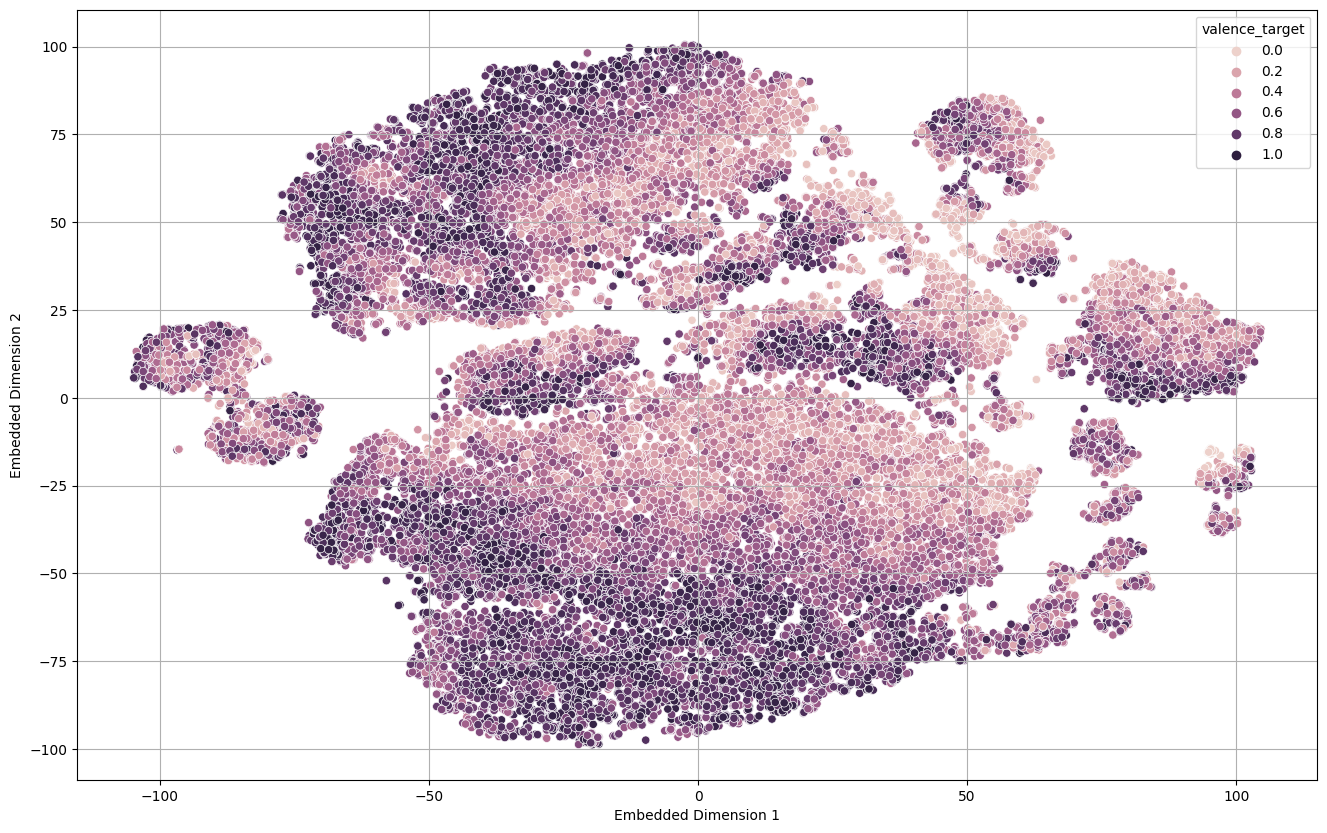

In [136]:
#  baseline model - Tsne 2d scatter plot based on resulting data


result_data, music_mood_list = baseline_model(train_data, train_features = train_features, sample_size = 50000)


In [137]:
# mood playlist for baseline


display(music_mood_list)

,music_name,valence_target,artist_name,music_id,music_popularity
0,Cool in the Pool,0.928,['Holger Czukay'],5rvOGr6TfBtdVZw6gF4zDE,17
1,Bola De Sabão,0.807,['Babado Novo'],36JLbOILRf2ELnpByw44qk,52
2,Zostawić Coś Po Sobie,0.414,['Paluch'],7vo9Jo7RNswCh5o2wfBQ9Z,39
3,Iron Man - 2012 - Remaster,0.427,['Black Sabbath'],3IOQZRcEkplCXg6LofKqE9,67
4,All About That Bass (Remix),0.971,['Workout Music '],6ExL9NmP0keIA99TJBcUBz,1
...,...,...,...,...,...
49995,Girl I Want You,0.928,['The Seeds'],0w4zimpvKpClrFjbx0bcsI,23
49996,Port,0.674,"['Krzysztof Klenczon', 'Trzy Korony']",49lpI9xuKSp2tdzntwE2RT,22
49997,Piano Man - Radio Edit,0.424,['Billy Joel'],70XHSOnNrWGZ91tX9soAFF,43
49998,Segaores,0.210,['Jarcha'],4rICotYlUlvhNSlNghveia,14


---
There are 5 observed music clusters based on the valence and embedded audio features
for the 50000 samples from our data used to fit the model

* music mood cluster 1 : 0.0 - 0.2 (min valence)
* music mood cluster 2 : 0.21 - 0.4 (low valence)
* music mood cluster 3 : 0.41 - 0.6 (neutral valence)
* music mood cluster 4 : 0.61 - 0.8 (high valence)
* music mood cluster 5 : 0.81 - 1.0 (max valence)

---



In [132]:
# content based recomendation system
# - music track recommendation in a random order using valence clusters based on t-sne baseline model 

# print recommendations based on mood cluster choice

playlist_length = 10 
#mood_choice = 'cluster3'
user_current_mood = 'cluster 1'
moodsic_playlist_choice = 'cluster 4'

mood_choice = {
        'user_current_mood' :'cluster1',
        'moodsic_playlist_choice':'cluster4'
}

def baseline_recommender(playlist_length= playlist_length, mood_choice= mood_choice, *args, **kwargs):
    if mood_choice['moodsic_playlist_choice'] == 'cluster1':
        query_data = music_mood_list.query("valence_target >= 0.0 & valence_target < 0.2")
    elif mood_choice['moodsic_playlist_choice'] == 'cluster2':
        query_data = music_mood_list.query("valence_target >= 0.2 & valence_target < 0.4")
    elif mood_choice['moodsic_playlist_choice'] == 'cluster3':
        query_data = music_mood_list.query("valence_target >= 0.4 & valence_target < 0.6")
    elif mood_choice['moodsic_playlist_choice'] == 'cluster4':
        query_data = music_mood_list.query("valence_target >= 0.6 & valence_target < 0.8")
    elif mood_choice['moodsic_playlist_choice'] == 'cluster5':
        query_data = music_mood_list.query("valence_target >= 0.8 & valence_target < 1.0")
    else:
        raise ValueError("Input mood cluster choice is unavailable( cluster1 to cluster5) only! ")

    print("________"*10)

    print(f"Recommended music tracks based on {mood_choice['moodsic_playlist_choice']} mood (valence): ")

    print("________"*10)

    for music in query_data:
        print(f" Enjoy these {playlist_length} music tracks from spotify")
        print("             "*10)
        n_mood_music = (query_data[['music_id',	'music_name', 'artist_name' , 'music_popularity']].sample(n=playlist_length, random_state = 42, replace=True))

        display(n_mood_music)
        # print dataframe with mui´sic name, by which artist and spotify url
        break


baseline_recommender(playlist_length = playlist_length, **mood_choice)

print("________"*10)
print("________"*10)


________________________________________________________________________________
Recommended music tracks based on cluster4 mood (valence): 
________________________________________________________________________________
 Enjoy these 10 music tracks from spotify
                                                                                                                                  


,music_id,music_name,artist_name,music_popularity
29539,4ACjj8thGto1rJh2HnV78c,有人 - Instrumental,['純音樂'],22
3545,1Wvls9LpxOk88CdcIcLIx2,Hum Aaj Kahin Dil Kho Baithe,['Mukesh'],12
21927,4YDs7H2OUMyoxbP59y4XMT,Tellin' Everybody,['Human Nature'],24
21218,1bvtss37d3Edl6AaLPHkta,You Are Not My Friend,['Frenzal Rhomb'],38
48752,1Q7gCIpOjIIU0bUKcGzrG4,I Feel Fine - Remastered 2009,['The Beatles'],38
46047,4PB7El6Pt5yvn5Q0uW9DKi,Fever,['James Brown & The Famous Flames'],17
23387,2GxRF7zoWQgLyRkXWBfRBN,อยากเจอ,['Blue Shade'],32
25411,3CEEw78EGAoOSBuwJljbOj,Chapter 64.2 & Chapter 65.1 - Dolina strachu,['Arthur Conan Doyle'],0
1952,0OvpfwyVoFwxZyifJas3mQ,自導自演,['Jay Chou'],22
18040,4sCun5HJnGrBrViEloKGpS,Pasión y Vida,['Los Angeles Negros'],40


________________________________________________________________________________
________________________________________________________________________________


In [122]:

# group music tracks by mood valence clusters and recommend list of user input choice

#mood_choice = 'cluster1'

#music_mood_list = result_data[['music_name', 'valence_target']]

#mood_labels = ["sad", "relaxed", "neutral", "excited", "happy"]
#mood_class = [0, 1, 2, 3, 4, 5]
#mood_valence_values =  [0.0 , 0.21, 0.41, 0.61, 0.81, 1.0]




# for next steps: other model

---
---

Proposed Valence - Energy values mapped to mood labels based on the russell-thayer 2 dimensional model of affect (circumplex model).

| Mood labels       | Valence values | Energy values |
|------------------|-----------------|---------------|
| Happy            | 0.9             | 0.7           |
| Joyful           | 0.8             | 0.8           |
| Energetic        | 0.7             | 0.9           |
| Excited          | 0.7             | 1.0           |
| Calm             | 0.8             | 0.3           |
| Peaceful         | 0.7             | 0.4           |
| Relaxed          | 0.6             | 0.3           |
| Content          | 0.7             | 0.5           |
| Sad              | 0.1             | 0.4           |
| Melancholic      | 0.2             | 0.3           |
| Gloomy           | 0.1             | 0.4           |
| Angry            | 0.2             | 0.8           |
| Agitated         | 0.3             | 0.9           |
| Tense            | 0.3             | 0.7           |
| Anxious          | 0.2             | 0.9           |
| Fearful          | 0.1             | 0.8           |


---
with the 2-D Circumplex model ; The adapted russell model of affect based on mood and arousal 

![2-D Circumplex model : The adapted russell model of affect based on mood and arousal](../images/Russells-circumplex-model-adapted.png)



where :

- valence = radius x cosine (theta in radians)
- arousal (energy) = radius x sine (theta in radians)



---
References

* [A multi-genre model for music emotion recognition using linear regressors](https://www.tandfonline.com/doi/epdf/10.1080/09298215.2021.1977336?needAccess=true&role=button)
* [Emotionally-Relevant Features for Classification and Regression of Music Lyrics](https://www.researchgate.net/publication/306006106_Emotionally-Relevant_Features_for_Classification_and_Regression_of_Music_Lyrics)

* [A Novel Emotion-Aware Hybrid Music Recommendation Method Using Deep Neural Network](https://pdfs.semanticscholar.org/ebe3/457cd5bc9dc30b5a6344d560ef07f0526c31.pdf?_gl=1*1dj28ia*_ga*MTk4OTA5NzI4OS4xNjkzMDc3NTk3*_ga_H7P4ZT52H5*MTY5MzEzNTM4Ni4yLjEuMTY5MzEzNjQ2OC4yOC4wLjA.)
* [MUSAV: A DATASET OF RELATIVE AROUSAL-VALENCE ANNOTATIONS FOR VALIDATION OF AUDIO MODELS](https://repositori.upf.edu/bitstream/handle/10230/56442/Serra_Pro_Musa.pdf?sequence=1)



In [41]:



#%pip install MulticoreTSNE
